# Toy - BNN for regression

arXiv:1505.05424v2

arXiv:2006.01490v2

arXiv:2309.16314v1

arXiv:2007.06823v3

arXiv:2006.12024v1

In [1]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080 Ti
Total GPU Memory: 11.8 GB


## 0. Code

Basic use of torch.distributions

In [5]:
n = 10
m = 3
loc = torch.randn((n,m))
scale = torch.exp(0.5 * torch.randn((n,m)))

base_dist = torch.distributions.Normal(
    loc = loc,
    scale = scale
)

print(f"Distribution before Independent reshape :\n\tbatch : {base_dist.batch_shape}, event : {base_dist.event_shape}")

dist = torch.distributions.Independent(base_dist,2)

print(f"Distribution after Independent reshape :\n\tbatch : {dist.batch_shape}, event : {dist.event_shape}")

Distribution before Independent reshape :
	batch : torch.Size([10, 3]), event : torch.Size([])
Distribution after Independent reshape :
	batch : torch.Size([]), event : torch.Size([10, 3])


In [6]:
samples = dist.rsample((7,))

print(f'{samples.size()}')

torch.Size([7, 10, 3])


### Basic Bayesian Linear class

In [7]:
class BayesianLinear(nn.Module):
    """
    Basic Bayesian Linear layer class.
    The weight and bias matrices are implemented as multivariate Gaussian torch.distributions,
        with mean and covariance as learnable Parameters.
    A weight and bias are sampled for each forward pass, with rsample so the output remains differentiable
        for the backprop.
    """
    def __init__(self,
                 out_dim,
                 in_dim,
                 w_prior_mean=0.0,
                 w_prior_logvar=1.0,
                 bias=None,
                 b_prior_mean=0.0,
                 b_prior_logvar=1.0,
    ):
        """
        - layer inputs x have dimension in_dim
        - layer outputs y have dimension out_dim
        - the weight matrix is W (out_dim, in_dim)
        - the bias matrix is b (out_dim, 1)
        - all dsitributions are mutlivariate Gaussians with diagonal covariance
        """
        super(BayesianLinear,self).__init__()
        # register non learnable parameters
        self.register_buffer("out_dim", torch.tensor([out_dim]))
        self.register_buffer("in_dim", torch.tensor([in_dim]))
        self.register_buffer("w_prior_mean", torch.tensor([w_prior_mean]))
        self.register_buffer("w_prior_logvar", torch.tensor([w_prior_logvar]))
        self.register_buffer("b_prior_mean", torch.tensor([b_prior_mean]))
        self.register_buffer("b_prior_logvar", torch.tensor([b_prior_logvar]))
        self.register_buffer("bias", bias)
        # instantiate priors
        # W
        self.w_prior_mean = (torch.ones(self.out_dim, self.in_dim) * self.w_prior_mean).to(device)
        self.w_prior_cov = (torch.exp(0.5* self.w_prior_logvar) * torch.ones(self.out_dim, self.in_dim)).to(device)
        base_dist = torch.distributions.Normal(loc=self.w_prior_mean, scale=self.w_prior_cov)
        self.w_prior_dist = torch.distributions.Independent(base_dist,2)
        # b
        self.b_prior_mean = (torch.ones(self.out_dim) * self.b_prior_mean).to(device)
        self.b_prior_cov = (torch.exp(0.5* self.b_prior_logvar) * torch.ones(self.out_dim)).to(device)
        base_dist = torch.distributions.Normal(loc=self.b_prior_mean, scale=self.b_prior_cov)
        self.b_prior_dist = torch.distributions.Independent(base_dist,1)
        # initialize posteriors
        # W
        self.w_post_mean = nn.Parameter(torch.zeros((self.out_dim, self.in_dim), device=device))
        self.w_post_cov = nn.Parameter(torch.ones((self.out_dim, self.in_dim), device=device) / math.sqrt(self.out_dim)) #, device=device)))
        base_dist = torch.distributions.Normal(loc=self.w_post_mean, scale=self.w_post_cov)
        self.w_post_dist = torch.distributions.Independent(base_dist,2)
        # b
        self.b_post_mean = nn.Parameter(torch.zeros(self.out_dim, device=device))
        self.b_post_cov = nn.Parameter(torch.ones(self.out_dim, device=device) / math.sqrt(self.out_dim)) #, device=device)))
        base_dist = torch.distributions.Normal(loc=self.b_post_mean, scale=self.b_post_cov)
        self.b_post_dist = torch.distributions.Independent(base_dist,1)
        
    def forward(self, x):
        """
        forward pass.
        inputs : x, tensor of size (in_dim) or (batch_dim, in_dim)
        outputs : Wx + b, tensor of size (out_dim) or (batch_dim, out_dim), with W and b sampled from posterior distributions.
        """
        w_s = self.w_post_dist.rsample()  # note rsample, not sample, so this stays differentiable
        b_s = self.b_post_dist.rsample()
        
        # F.linear manages potential extra batch dimension
        return F.linear(x, w_s, b_s)
    
    def __repr__(self):
        msg = f'Bayesian linear layer\n'
        msg += f'\tinput dimension : {self.in_dim}\n'
        msg += f'\toutput dimension : {self.out_dim}\n'
        msg += f'\tw prior mean (shape) : {self.w_prior_mean.shape}\n'
        msg += f'\tw prior cov (shape) : {self.w_prior_cov.shape}\n'
        msg += f'\tb prior mean (shape) : {self.b_prior_mean.shape}\n'
        msg += f'\tb prior cov (shape) : {self.b_prior_cov.shape}\n'
        return msg

In [8]:
out_dim = 3
in_dim = 10

l = BayesianLinear(out_dim=out_dim, in_dim=in_dim).to(device)
print(l)

Bayesian linear layer
	input dimension : tensor([10], device='cuda:0')
	output dimension : tensor([3], device='cuda:0')
	w prior mean (shape) : torch.Size([3, 10])
	w prior cov (shape) : torch.Size([3, 10])
	b prior mean (shape) : torch.Size([3])
	b prior cov (shape) : torch.Size([3])



In [9]:
batch_size=4
x = torch.randn(batch_size,in_dim).to(device)
print(x)

tensor([[ 0.5716,  1.3596,  0.4334, -0.7172,  1.0554, -1.4534,  0.4652,  0.3714,
          0.8800,  0.0561],
        [ 0.3782,  0.7051, -1.7237, -0.8435,  0.4351,  0.2659,  0.0367,  0.4934,
          0.8854,  0.1824],
        [ 0.7864, -0.0579,  0.5667, -0.7098, -0.5513,  1.9890,  0.8479, -0.6953,
          0.3056,  0.2909],
        [ 0.4085, -1.2609, -0.3947,  1.8868,  0.1787, -0.0385, -0.0869, -1.1803,
          1.5460,  0.5448]], device='cuda:0')


In [10]:
y = l(x)
print(y)

tensor([[-0.3970, -2.8368,  0.3122],
        [ 0.2660,  0.0346, -1.2021],
        [ 0.9436,  1.0799, -0.3708],
        [-0.0365,  0.1152,  2.1156]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Function to compute the sum of KL for each Bayesian layer

In [11]:
def bnn_kl_loss(model):
    """
    Compute the aggregate KL(posterior | prior) for all layers in the model
    - model : this is the full MLP. we iterate on all layers, assumed Bayesian Linear objects, to compute losses
    """
    kl_total = torch.tensor([0.0]).to(device)
    for m in model.modules():
        if isinstance(m, BayesianLinear):
            # print(m)
            kl_total += torch.distributions.kl_divergence(m.w_post_dist, m.w_prior_dist)
            kl_total += torch.distributions.kl_divergence(m.b_post_dist, m.b_prior_dist)
        
    # the implicit reduction method is 'sum' here, not average
    return kl_total

In [12]:
model = nn.Sequential(
    BayesianLinear(100,10),
    nn.ReLU(),
    BayesianLinear(1,100)
)
y = model(x)
loss = bnn_kl_loss(model)
print(f'Loss : {loss}')

Loss : tensor([2553.4446], device='cuda:0', grad_fn=<AddBackward0>)


### Function to compute the average L2 loss between outputs and ground truth

In [13]:
def bnn_rec_loss(y, x, model, K=3):
    """
    Compute the average L2 loss of the model outputs wrt ground truth y
    This is not exactly the negative log likelihood, but this is hopefully close enough
    inputs :
    - y : ground truth outputs, shape (out_dim,)
    - x : input data (batch_size, in_dim)
    - model : Bayesian MLP to use
    - K (default to 3) : number of samples to compute the expectation
    """
    for k in range(K):
        y_output = model(x)
        if k==0:
            y_outputs = y_output.clone().unsqueeze(0)
        else:
            y_outputs = torch.cat([y_outputs, y_output.clone().unsqueeze(0)], axis=0)
            
    # print(f'y_outputs (shape) : {y_outputs.shape}')
    
    rec_loss = (y_outputs - y)**2  # broadcast
    rec_loss = rec_loss.mean()

    return rec_loss

## 1. Generate Sample Data

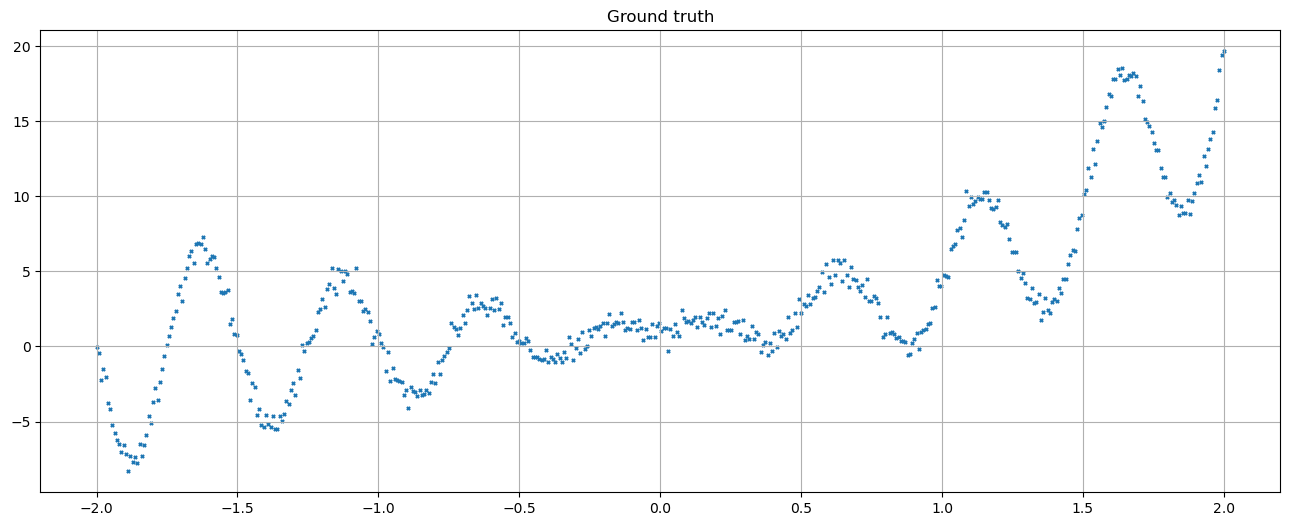

In [14]:
x = torch.linspace(-2, 2, 500)
sigma=0.5

functions = {}
functions['polynome'] = lambda x : x.pow(3) - x.pow(2) + 3*torch.rand(x.size())
functions['sinusoide'] = lambda x : x * torch.sin(x * 2 * torch.pi) + torch.randn(x.size())*sigma
functions['exp'] = lambda x : torch.exp(1.5 * x) + 4 * x * torch.sin(x * 4 * torch.pi) + torch.randn(x.size())*sigma

function_name = 'exp'
y = functions.get(function_name)(x)

x = torch.unsqueeze(x, dim=1).to(device)
y = torch.unsqueeze(y, dim=1).to(device)

fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(x.detach().cpu().data.numpy(), y.detach().cpu().data.numpy(), marker='x',s=5)
ax.grid(True)
ax.set_title(f'Ground truth')

plt.show()

## 2. Define Model

In [15]:
hidden_dim = 16
n_hidden_layers = 4

list_hidden_layers =     [
    BayesianLinear(out_dim=hidden_dim, in_dim=hidden_dim),
    nn.Tanh(), 
    ] * n_hidden_layers

model = nn.Sequential(
    BayesianLinear(out_dim=hidden_dim, in_dim=1),
    nn.Tanh(),
    *list_hidden_layers,
    BayesianLinear(out_dim=1, in_dim=hidden_dim)
).to(device)

print(model)

Sequential(
  (0): Bayesian linear layer
  	input dimension : tensor([1], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 1])
  	w prior cov (shape) : torch.Size([16, 1])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (1): Tanh()
  (2): Bayesian linear layer
  	input dimension : tensor([16], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 16])
  	w prior cov (shape) : torch.Size([16, 16])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (3): Tanh()
  (4): Bayesian linear layer
  	input dimension : tensor([16], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 16])
  	w prior cov (shape) : torch.Size([16, 16])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (5): Tanh()
  (6): Bay

In [16]:
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

## 3. Train Model

In [17]:
kl_weight = 1e-4
K = 3
n_epochs = 50000

filesave = '/home/benjamin/Folders_Python/Bayesian_NN/model.pth'

In [18]:
kls = []
mses = []
losses = []

best_loss = np.inf

for step in range(n_epochs):
    kl = bnn_kl_loss(model)
    rec_loss = bnn_rec_loss(y,x,model,K=K)
    loss = kl_weight*kl + rec_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    kls.append(kl.item())
    mses.append(rec_loss.item())
    losses.append(loss.item())
    
    msg = f'Epoch {step+1:<6} - {n_epochs:<6} - Total loss : {loss.item():.3e}, MSE : {rec_loss.item():.3e}, KL : {kl.item():.3e}'
    if loss.item() < best_loss:
        torch.save(model.state_dict(), filesave)
        msg += f' - saving model'
        best_loss = loss.item()
    
    print(msg + " "*50, end="\r")
    
print(f'\nBest loss : {best_loss:.3e}')

Epoch 50000  - 50000  - Total loss : 1.295e+00, MSE : 1.144e+00, KL : 1.507e+03                                                                 
Best loss : 6.779e-01


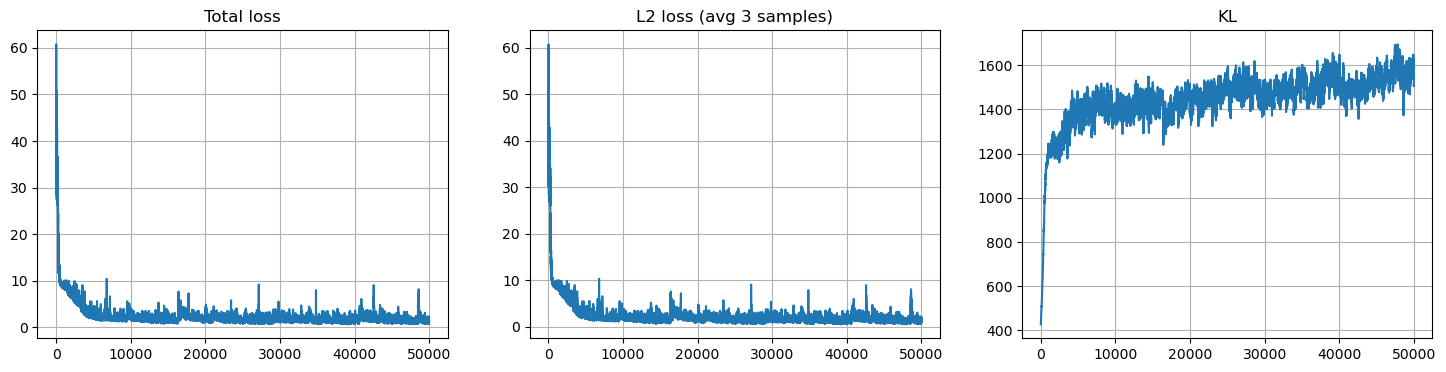

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

ax[0].set_title('Total loss')
ax[0].plot(losses)
ax[0].grid()

ax[1].set_title(f'L2 loss (avg {K} samples)')
ax[1].plot(mses)
ax[1].grid()

ax[2].set_title(f'KL')
ax[2].plot(kls)
ax[2].grid()

## 4. Test Model

In [20]:
state = torch.load(filesave, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

Sequential(
  (0): Bayesian linear layer
  	input dimension : tensor([1], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 1])
  	w prior cov (shape) : torch.Size([16, 1])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (1): Tanh()
  (2): Bayesian linear layer
  	input dimension : tensor([16], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 16])
  	w prior cov (shape) : torch.Size([16, 16])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (3): Tanh()
  (4): Bayesian linear layer
  	input dimension : tensor([16], device='cuda:0')
  	output dimension : tensor([16], device='cuda:0')
  	w prior mean (shape) : torch.Size([16, 16])
  	w prior cov (shape) : torch.Size([16, 16])
  	b prior mean (shape) : torch.Size([16])
  	b prior cov (shape) : torch.Size([16])
  
  (5): Tanh()
  (6): Bay

In [21]:
x_test = torch.linspace(-2, 2, 500)
y_test = functions.get(function_name)(x_test)

x_test = torch.unsqueeze(x_test, dim=1).to(device)
y_test = torch.unsqueeze(y_test, dim=1).to(device)

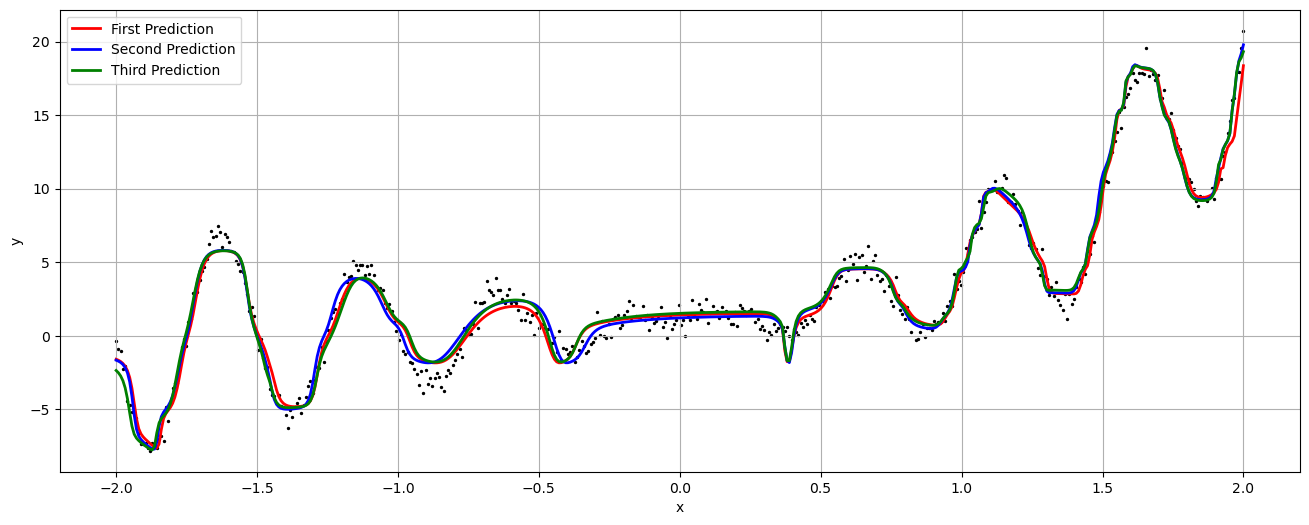

In [22]:
fig, ax = plt.subplots(figsize=(16,6))

ax.set_xlabel('x')
ax.set_ylabel('y')

x_t = x_test.detach().cpu().numpy()

ax.scatter(x_t, y_test.detach().cpu().numpy(), color='k', s=2) 

y_predict = model(x_test)
ax.plot(x_t, y_predict.detach().cpu().numpy(), 'r-', linewidth=2, label='First Prediction')

y_predict = model(x_test)
ax.plot(x_t, y_predict.detach().cpu().numpy(), 'b-', linewidth=2, label='Second Prediction')

y_predict = model(x_test)
ax.plot(x_t, y_predict.detach().cpu().numpy(), 'g-', linewidth=2, label='Third Prediction')

ax.legend()
ax.grid()

plt.show()

In [23]:
results = f'function_name = {function_name} -- noise = {sigma} -- epochs = {n_epochs} -- kl_weight = {kl_weight:.3e} -- K = {K} -- num_hidden_layers = {n_hidden_layers} -- hidden_dim = {hidden_dim} -- best_loss = {best_loss:.3e}'
print(results)

function_name = exp -- noise = 0.5 -- epochs = 50000 -- kl_weight = 1.000e-04 -- K = 3 -- num_hidden_layers = 4 -- hidden_dim = 16 -- best_loss = 6.779e-01


In [24]:
resultsfile = '/home/benjamin/Folders_Python/Bayesian_NN/results.txt'
with open(resultsfile,'a') as f:
    f.write(results+'\n')